In [1]:
import pandas as pd
import numpy as np

import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from itertools import permutations
from scipy.stats import ttest_ind
import arviz as az

import causalpy as cp

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [93]:
# Constants
random_state = 42

## Data Preperation

In [180]:
# Load in claims data by dma, city, state from 2024-01-01 onwards
claims = pd.read_csv('claims_by_dma_10_24_24.csv')
claims

,date,dma_name,city,state,new_persons,returning_persons,claims
0,2024-08-06,Orlando-Daytona Bch-Melbrn,Flagler Beach,FL,2,13,17
1,2024-08-06,Champaign&Sprngfld-Decatur,Danville,IL,4,31,40
2,2024-08-02,Chicago,Joliet,IL,11,63,85
3,2024-08-04,Phoenix (Prescott),Cave Creek,AZ,1,28,32
4,2024-08-07,Madison,Verona,WI,3,9,13
...,...,...,...,...,...,...,...
1869057,2024-07-10,New York,Budd Lake,NJ,0,5,6
1869058,2024-06-17,Boise,Payette,ID,1,11,13
1869059,2024-02-08,Milwaukee,Twin Lakes,WI,0,8,9
1869060,2024-07-26,Myrtle Beach-Florence,Loris,SC,0,2,2


In [181]:
# Add/Modify columns
claims['city_state'] = claims['city'] + ', ' + claims['state']
claims['date'] = pd.to_datetime(claims['date'])

In [182]:
# Swing State Boolean
claims['swing_state_bool'] = np.where(claims['state'].isin(['AZ', 'NV', 'WI', 'MI', 'PA', 'GA', 'NC']), 1, 0)

swing_state_dmas = claims[claims['swing_state_bool'] == 1].dma_name.unique()
non_swing_dmas = claims[claims['swing_state_bool'] == 0].dma_name.unique()

In [183]:
# Andriod Tier Boolen
tier_1 = ['CA', 'WI', 'KY', 'ME', 'IL', 'ND', 'NV', 'TN', 'HI', 'MI', 'AZ',
          'NJ', 'VT', 'AK', 'ID', 'SC', 'NE', 'MT', 'IN', 'WY', 'MD', 'OR',
          'CT', 'OH', 'IA', 'CO', 'RI', 'VA', 'DE', 'WA']

tier_2 = ['MA', 'GA', 'UT', 'MN', 'SD', 'AL', 'TX', 'KS', 'MS', 'MO', 'NY',
          'FL', 'DC', 'LA', 'NC', 'NM', 'WV', 'PA', 'OK', 'NH', 'AR']

claims['android_tier'] = np.where(claims['state'].isin(tier_1), 1, 2)

# Update tier if dma has cities in both tiers, based on where most claims are from
for dma in claims.dma_name.unique():
    claims_data = claims.copy()[claims['dma_name'] == dma]
    state_list = claims_data.state.unique()
    states_in_teir_1 = len([x for x in state_list if x in tier_1])
    states_in_teir_2 = len([x for x in state_list if x in tier_2])

    if states_in_teir_1 > 0 and states_in_teir_2 > 0:
        dma_top_state = claims_data[['state', 'claims']].groupby('state').sum().sort_values('claims', ascending = False).index[0]
        
        if dma_top_state in tier_1:
            top_state_tier = 1
        else:
            top_state_tier = 2
        claims['android_tier'] = np.where(claims['dma_name'] == dma, top_state_tier, claims['android_tier'])
        
android_teir_1 = claims[claims['android_tier'] == 1].dma_name.unique()
android_teir_2 = claims[claims['android_tier'] == 2].dma_name.unique()

In [184]:
# Group by DMA
claims_dma = claims[['date', 'dma_name', 'new_persons', 'returning_persons', 'claims']].groupby(['date', 'dma_name']).sum().reset_index()

In [185]:
# Create new df with statistics
dma_grouped_df = claims_dma.groupby('dma_name').agg(
    count_date=('date', 'count'),
    avg_new_persons=('new_persons', 'mean'),
    sd_new_persons=('new_persons', 'std'),
    avg_returning_persons=('returning_persons', 'mean'),
    sd_returning_persons=('returning_persons', 'std'), 
    avg_claims = ('claims', 'mean'),
    sd_claims = ('claims', 'std'), 
).reset_index()

dma_grouped_df.head(5)

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Abilene-Sweetwater,298,39.882550,13.985188,313.020134,112.014217,411.624161,147.584592
1,"Albany, GA",298,39.409396,13.911463,290.016779,88.285406,387.382550,119.570055
2,Albany-Schenectady-Troy,298,92.127517,30.091508,505.899329,142.837373,664.989933,191.304849
3,Albuquerque-Santa Fe,298,176.214765,54.360632,911.781879,262.518178,1240.231544,364.449601
4,"Alexandria, LA",298,18.939597,7.411183,143.322148,43.418683,184.147651,56.879147


## Segmentation

In [186]:
# Break out by tier, break out by quantile for each tier
dma_grouped_df['android_tier'] = np.where(dma_grouped_df['dma_name'].isin(android_teir_1), 1, 2)

dma_grouped_df_tier_1 = dma_grouped_df.copy()[dma_grouped_df['android_tier'] == 1].reset_index()
dma_grouped_df_tier_2 = dma_grouped_df.copy()[dma_grouped_df['android_tier'] == 2].reset_index()

dma_grouped_df_tier_1['quantile'] = pd.qcut(dma_grouped_df_tier_1['avg_claims'], q=4, labels=False)
dma_grouped_df_tier_2['quantile'] = pd.qcut(dma_grouped_df_tier_2['avg_claims'], q=4, labels=False)

In [187]:
stratifier = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

# Tier 1 Statify
dma_grouped_df_tier_1['group'] = 0  # Initialize the group column
for i, (_, test_index) in enumerate(stratifier.split(dma_grouped_df_tier_1, dma_grouped_df_tier_1['quantile'])):
    dma_grouped_df_tier_1.loc[test_index, 'group'] = i + 1

# Tier 2 Statify
dma_grouped_df_tier_2['group'] = 0  # Initialize the group column
for i, (_, test_index) in enumerate(stratifier.split(dma_grouped_df_tier_2, dma_grouped_df_tier_2['quantile'])):
    dma_grouped_df_tier_2.loc[test_index, 'group'] = i + 1

# Concat and display
dma_grouped_df = pd.concat([dma_grouped_df_tier_1.set_index('index'), dma_grouped_df_tier_2.set_index('index')]).sort_index()
dma_grouped_df

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group
index,,,,,,,,,,,
0,Abilene-Sweetwater,298,39.882550,13.985188,313.020134,112.014217,411.624161,147.584592,2,1,2
1,"Albany, GA",298,39.409396,13.911463,290.016779,88.285406,387.382550,119.570055,2,1,3
2,Albany-Schenectady-Troy,298,92.127517,30.091508,505.899329,142.837373,664.989933,191.304849,2,2,3
3,Albuquerque-Santa Fe,298,176.214765,54.360632,911.781879,262.518178,1240.231544,364.449601,2,2,2
4,"Alexandria, LA",298,18.939597,7.411183,143.322148,43.418683,184.147651,56.879147,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...
205,Wilmington,298,74.714765,23.621507,515.459732,152.061878,659.533557,196.625729,2,2,2
206,Yakima-Pasco-Rchlnd-Knnwck,298,54.248322,17.328246,362.758389,110.960827,476.026846,144.819193,1,1,4
207,Youngstown,298,61.798658,22.598227,426.328859,141.948155,554.956376,187.875437,1,1,2


In [188]:
# Segment statistics
grouped_df_stats = dma_grouped_df.groupby('group').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims =('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

grouped_df_stats

,group,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,1,7454.785235,2296.433560,43681.744966,12865.752526,58466.171141,17431.064330
1,2,6647.073826,2080.206262,40085.469799,11843.614594,52826.879195,15801.767817
2,3,7147.157718,2209.283771,42429.657718,12418.549970,56759.848993,16809.425140
3,4,7165.423151,2161.135590,45442.584339,13137.484886,60262.013400,17590.934980


### Treatment and Control Creation

In [189]:
# Create a mapping from the new groupings to mobile segments
youtube_mapping = {group: segment for group, segment in
                  zip([1, 2, 3, 4], (['Treatment']* 2) + (['Control']*2))}
dma_grouped_df['youtube_segments'] = dma_grouped_df['group'].map(youtube_mapping)

# Create a mapping from the new groupings to mobile segments
app_mapping = {group: segment for group, segment in
                  zip([1, 3, 2, 4], (['Treatment']*2) + (['Control']*2))}
dma_grouped_df['app_segments'] = dma_grouped_df['group'].map(app_mapping)

dma_grouped_df.head()

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group,youtube_segments,app_segments
index,,,,,,,,,,,,,
0,Abilene-Sweetwater,298,39.882550,13.985188,313.020134,112.014217,411.624161,147.584592,2,1,2,Treatment,Control
1,"Albany, GA",298,39.409396,13.911463,290.016779,88.285406,387.382550,119.570055,2,1,3,Control,Treatment
2,Albany-Schenectady-Troy,298,92.127517,30.091508,505.899329,142.837373,664.989933,191.304849,2,2,3,Control,Treatment
3,Albuquerque-Santa Fe,298,176.214765,54.360632,911.781879,262.518178,1240.231544,364.449601,2,2,2,Treatment,Control
4,"Alexandria, LA",298,18.939597,7.411183,143.322148,43.418683,184.147651,56.879147,2,0,3,Control,Treatment


In [190]:
# Check Mobile Segments
app_df_stats = dma_grouped_df.groupby('app_segments').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims=('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

app_df_stats

,app_segments,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Control,13812.496976,4241.341851,85528.054138,24981.099480,113088.892595,33392.702797
1,Treatment,14601.942953,4505.717332,86111.402685,25284.302496,115226.020134,34240.489470


In [191]:
# Check YouTube Segments
youtube_df_stats = dma_grouped_df.groupby('youtube_segments').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims=('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

youtube_df_stats

,youtube_segments,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Control,14312.580869,4370.419361,87872.242057,25556.034856,117021.862393,34400.360119
1,Treatment,14101.859060,4376.639822,83767.214765,24709.367120,111293.050336,33232.832147


## Test Set-up Checks

In [192]:
# Build Claims pivots by date
claims_np = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='new_persons')
claims_rp = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='returning_persons')
claims_cl = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='claims')

In [193]:
def filter_and_group_data(claims_df, dma_grouped_df, segment_col, segment_value):
    """
    Filters the claims dataframe by a given segment and groups by date and dma, summing the metrics.
    """
    return claims_df[claims_df['dma_name'].isin(dma_grouped_df[dma_grouped_df[segment_col] == segment_value].dma_name)][
        ['date', 'dma_name', 'new_persons', 'returning_persons', 'claims']
    ].groupby(['date', 'dma_name']).sum().reset_index()

def create_pivot(df, value_col):
    """
    Creates a pivot table from the grouped dataframe, pivoting by date and dma for the specified value column.
    """
    return df.pivot(index='date', columns='dma_name', values=value_col)

# Create dataframes for mobile segments
app_treatment = filter_and_group_data(claims, dma_grouped_df, 'app_segments', 'Treatment')
app_control = filter_and_group_data(claims, dma_grouped_df, 'app_segments', 'Control')

# Create pivots for mobile segments
app_treatment_np = create_pivot(app_treatment, 'new_persons')
app_control_np = create_pivot(app_control, 'new_persons')

app_treatment_rp = create_pivot(app_treatment, 'returning_persons')
app_control_rp = create_pivot(app_control, 'returning_persons')

app_treatment_cl = create_pivot(app_treatment, 'claims')
app_control_cl = create_pivot(app_control, 'claims')

# Create dataframes for YouTube segments
youtube_treatment = filter_and_group_data(claims, dma_grouped_df, 'youtube_segments', 'Treatment')
youtube_control = filter_and_group_data(claims, dma_grouped_df, 'youtube_segments', 'Control')

# Create pivots for YouTube segments
youtube_treatment_np = create_pivot(youtube_treatment, 'new_persons')
youtube_control_np = create_pivot(youtube_control, 'new_persons')

youtube_treatment_rp = create_pivot(youtube_treatment, 'returning_persons')
youtube_control_rp = create_pivot(youtube_control, 'returning_persons')

youtube_treatment_cl = create_pivot(youtube_treatment, 'claims')
youtube_control_cl = create_pivot(youtube_control, 'claims')

In [194]:
# Create total time series for each segment, new persons
claims_np_sum = claims_np.sum(axis = 1)
app_treatment_np_sum = app_treatment_np.sum(axis=1)
app_control_np_sum = app_control_np.sum(axis=1)

# returning persons
claims_rp_sum = claims_rp.sum(axis = 1)
app_treatment_rp_sum = app_treatment_rp.sum(axis=1)
app_control_rp_sum = app_control_rp.sum(axis=1)

# total claims
claims_cl_sum = claims_cl.sum(axis = 1)
app_treatment_cl_sum = app_treatment_cl.sum(axis=1)
app_control_cl_sum = app_control_cl.sum(axis=1)

# Create total time series for each segment, new persons
claims_np_sum = claims_np.sum(axis = 1)
youtube_treatment_np_sum = youtube_treatment_np.sum(axis=1)
youtube_control_np_sum = youtube_control_np.sum(axis=1)

# returning persons
claims_rp_sum = claims_rp.sum(axis = 1)
youtube_treatment_rp_sum = youtube_treatment_rp.sum(axis=1)
youtube_control_rp_sum = youtube_control_rp.sum(axis=1)

# total claims
claims_cl_sum = claims_cl.sum(axis = 1) 
youtube_treatment_cl_sum = youtube_treatment_cl.sum(axis=1)
youtube_control_cl_sum = youtube_control_cl.sum(axis=1)

### Tier Distribution

In [195]:
tier_1_dmas = dma_grouped_df[dma_grouped_df['android_tier'] == 1]
tier_1_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,6447.661406,40057.976957,52742.899306
Treatment,5965.308725,35391.117450,47182.523490


In [196]:
tier_2_dmas = dma_grouped_df[dma_grouped_df['android_tier'] == 2]
tier_2_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,7364.835570,45470.077181,60345.993289
Treatment,8636.634228,50720.285235,68043.496644


### Swing State Distribution

In [197]:
swing_state_dmas

array(['Phoenix (Prescott)', 'Madison', 'Philadelphia', 'Pittsburgh',
       'Atlanta', 'Charlotte', 'Grand Rapids-Kalmzoo-B.Crk',
       'Flint-Saginaw-Bay City', 'Reno', 'Detroit',
       'Raleigh-Durham (Fayetvlle)', 'Greenville-N.Bern-Washngtn',
       'Macon', 'Harrisburg-Lncstr-Leb-York', 'Milwaukee',
       'South Bend-Elkhart', 'Las Vegas', 'Greenvll-Spart-Ashevll-And',
       'Greensboro-H.Point-W.Salem', 'Wilkes Barre-Scranton-Hztn',
       'Wilmington', 'Yuma-El Centro', 'Savannah', 'Chattanooga',
       'Toledo', 'Albany, GA', 'Tucson (Sierra Vista)', 'Erie',
       'La Crosse-Eau Claire', 'Augusta-Aiken', 'Wausau-Rhinelander',
       'Johnstown-Altoona-St Colge', 'Columbus, GA (Opelika, AL)',
       'Norfolk-Portsmth-Newpt Nws', 'Youngstown', 'Minneapolis-St. Paul',
       'Jacksonville', 'Tallahassee-Thomasville', 'Lansing',
       'Traverse City-Cadillac', 'Green Bay-Appleton', 'Alpena',
       'Myrtle Beach-Florence', 'Duluth-Superior', 'New York', 'Buffalo',
       'Do

In [198]:
swing_dmas = dma_grouped_df[dma_grouped_df['dma_name'].isin(swing_state_dmas)]

swing_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,3655.600671,24155.701342,31657.734899
Treatment,5633.808725,31710.221477,42733.412752


In [199]:
swing_dmas[['youtube_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('youtube_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
youtube_segments,,,
Control,4825.342282,31287.597315,41414.050336
Treatment,4464.067114,24578.325503,32977.097315


### National Representativeness

R² NP (Scaled Treatment 1): 0.9991
R² NP (Scaled Control): 0.9991
R² CL (Scaled Treatment 1): 0.9997
R² CL (Scaled Control): 0.9997
R² RP (Scaled Treatment 1): 0.9997
R² RP (Scaled Control): 0.9997


/var/folders/n4/96b1c6px5kz8sdgcmpq0wy7h0000gp/T/ipykernel_48712/3226523411.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


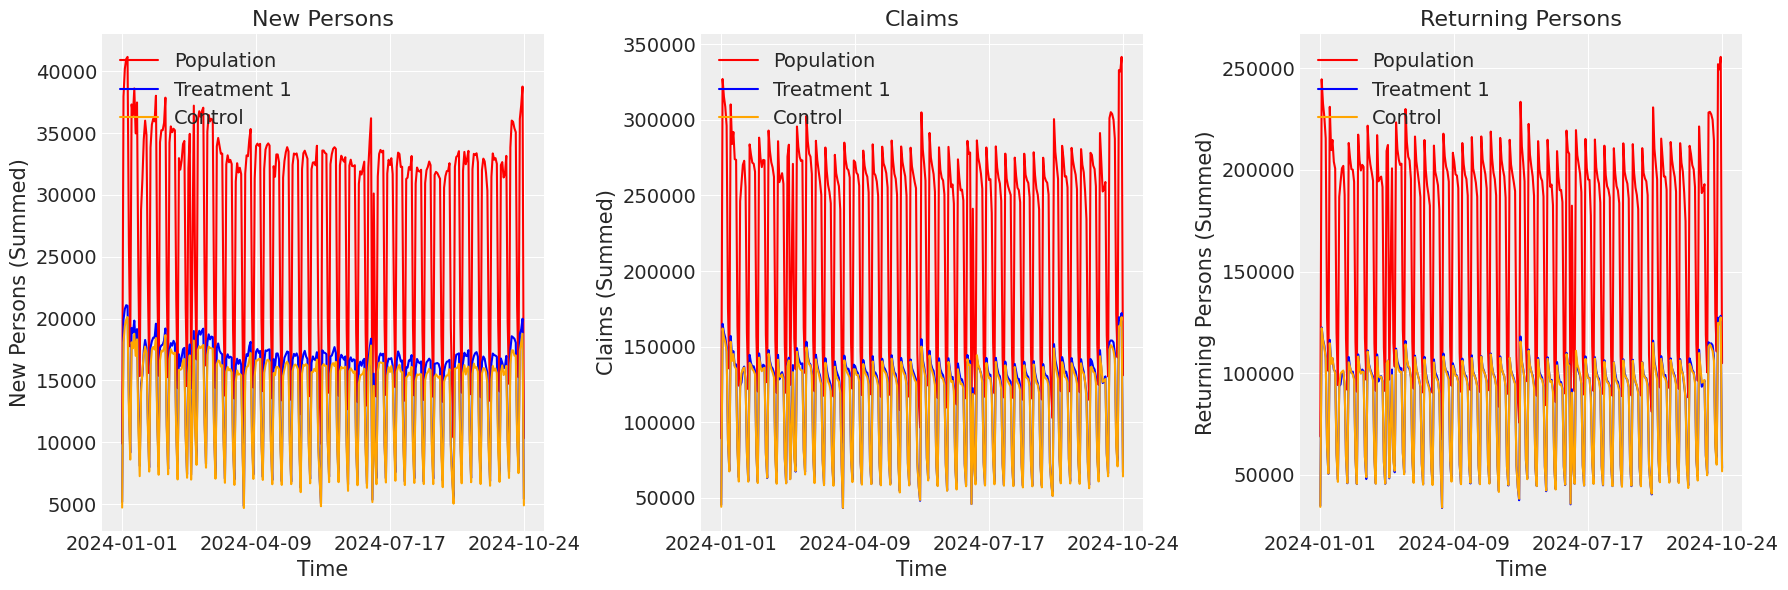

In [200]:
# App

# Set up a 1x3 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Choose a reduced number of ticks for the x-axis
ticks = claims_np_sum.index[::len(claims_np_sum)//3]  # Take 3 evenly spaced dates

# Plot for New Persons (NP)
axes[0].plot(claims_np_sum, label='Population', color='red')
axes[0].plot(app_treatment_np_sum, label='Treatment 1', color='blue')
axes[0].plot(app_control_np_sum, label='Control', color='orange')
axes[0].set_title('New Persons')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('New Persons (Summed)')
axes[0].legend(loc='upper left')  # Set legend position to top-left
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks.strftime('%Y-%m-%d'))  # Format date labels

# Calculate and print R² values for NP
treatment_r2_np = r2_score((app_treatment_np_sum * (claims_np_sum.sum() / app_treatment_np_sum.sum())), claims_np_sum)
control_r2_np = r2_score((app_control_np_sum * (claims_np_sum.sum() / app_control_np_sum.sum())), claims_np_sum)

print(f"R² NP (Scaled Treatment 1): {treatment_r2_np:.4f}")
print(f"R² NP (Scaled Control): {control_r2_np:.4f}")

# Plot for Claims (CL)
axes[1].plot(claims_cl_sum, label='Population', color='red')
axes[1].plot(app_treatment_cl_sum, label='Treatment 1', color='blue')
axes[1].plot(app_control_cl_sum, label='Control', color='orange')
axes[1].set_title('Claims')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Claims (Summed)')
axes[1].legend(loc='upper left')  # Set legend position to top-left
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for CL
treatment_r2_cl = r2_score((app_treatment_cl_sum * (claims_cl_sum.sum() / app_treatment_cl_sum.sum())), claims_cl_sum)
control_r2_cl = r2_score((app_control_cl_sum * (claims_cl_sum.sum() / app_control_cl_sum.sum())), claims_cl_sum)

print(f"R² CL (Scaled Treatment 1): {treatment_r2_cl:.4f}")
print(f"R² CL (Scaled Control): {control_r2_cl:.4f}")

# Plot for Returning Persons (RP)
axes[2].plot(claims_rp_sum, label='Population', color='red')
axes[2].plot(app_treatment_rp_sum, label='Treatment 1', color='blue')
axes[2].plot(app_control_rp_sum, label='Control', color='orange')
axes[2].set_title('Returning Persons')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Returning Persons (Summed)')
axes[2].legend(loc='upper left')  # Set legend position to top-left
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for RP
treatment_r2_rp = r2_score((app_treatment_rp_sum * (claims_rp_sum.sum() / app_treatment_rp_sum.sum())), claims_rp_sum)
control_r2_rp = r2_score((app_control_rp_sum * (claims_rp_sum.sum() / app_control_rp_sum.sum())), claims_rp_sum)

print(f"R² RP (Scaled Treatment 1): {treatment_r2_rp:.4f}")
print(f"R² RP (Scaled Control): {control_r2_rp:.4f}")

# Adjust layout and display the combined plot
plt.tight_layout()
plt.show()

R² NP (Scaled Treatment 1): 0.9991
R² NP (Scaled Control): 0.9991
R² CL (Scaled Treatment 1): 0.9995
R² CL (Scaled Control): 0.9996


/var/folders/n4/96b1c6px5kz8sdgcmpq0wy7h0000gp/T/ipykernel_48712/2222650956.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


R² RP (Scaled Treatment 1): 0.9996
R² RP (Scaled Control): 0.9996


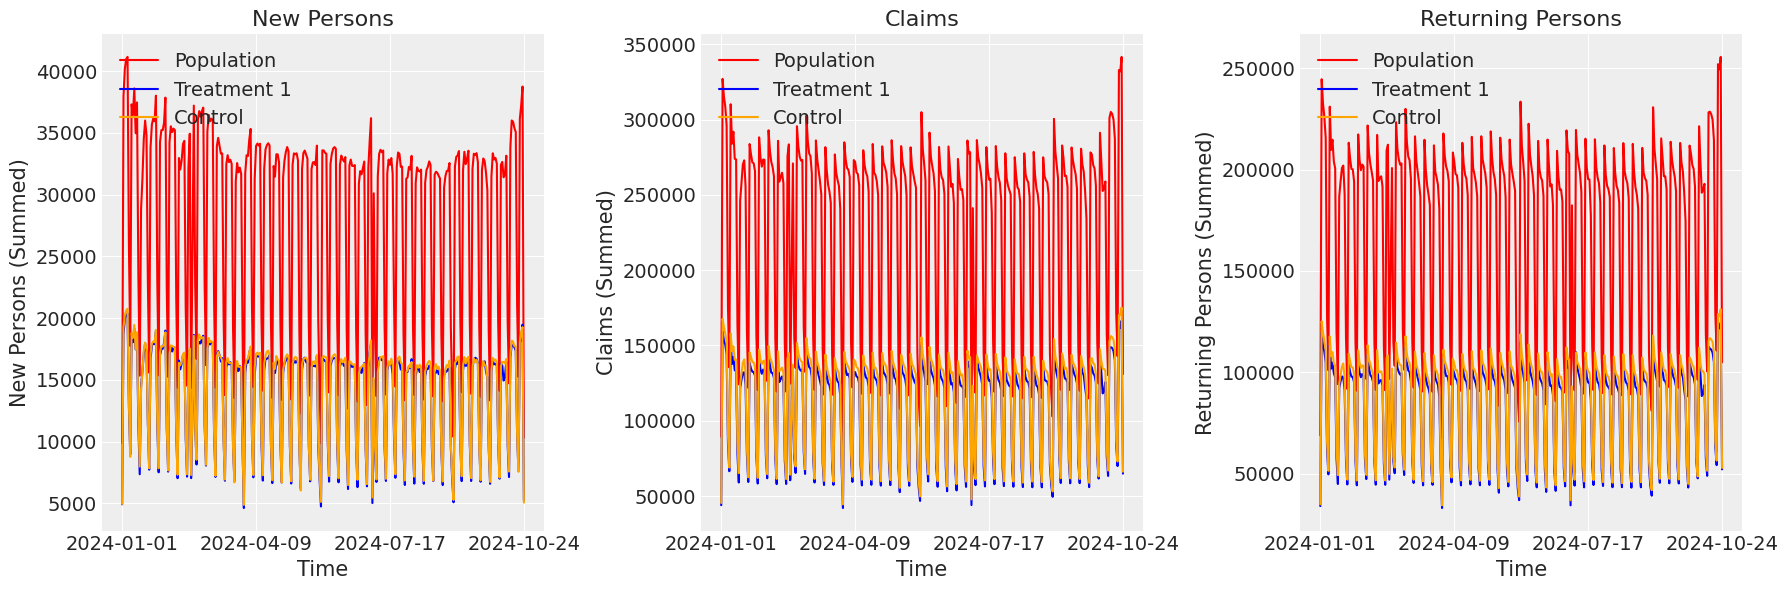

In [201]:
# YouTube

# Set up a 1x3 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Choose a reduced number of ticks for the x-axis
ticks = claims_np_sum.index[::len(claims_np_sum)//3]  # Take 3 evenly spaced dates

# Plot for New Persons (NP)
axes[0].plot(claims_np_sum, label='Population', color='red')
axes[0].plot(youtube_treatment_np_sum, label='Treatment 1', color='blue')
axes[0].plot(youtube_control_np_sum, label='Control', color='orange')
axes[0].set_title('New Persons')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('New Persons (Summed)')
axes[0].legend(loc='upper left')  # Set legend position to top-left
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks.strftime('%Y-%m-%d'))  # Format date labels

# Calculate and print R² values for NP
treatment_r2_np = r2_score((youtube_treatment_np_sum * (claims_np_sum.sum() / youtube_treatment_np_sum.sum())), claims_np_sum)
control_r2_np = r2_score((youtube_control_np_sum * (claims_np_sum.sum() / youtube_control_np_sum.sum())), claims_np_sum)

print(f"R² NP (Scaled Treatment 1): {treatment_r2_np:.4f}")
print(f"R² NP (Scaled Control): {control_r2_np:.4f}")

# Plot for Claims (CL)
axes[1].plot(claims_cl_sum, label='Population', color='red')
axes[1].plot(youtube_treatment_cl_sum, label='Treatment 1', color='blue')
axes[1].plot(youtube_control_cl_sum, label='Control', color='orange')
axes[1].set_title('Claims')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Claims (Summed)')
axes[1].legend(loc='upper left')  # Set legend position to top-left
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for CL
treatment_r2_cl = r2_score((youtube_treatment_cl_sum * (claims_cl_sum.sum() / youtube_treatment_cl_sum.sum())), claims_cl_sum)
control_r2_cl = r2_score((youtube_control_cl_sum * (claims_cl_sum.sum() / youtube_control_cl_sum.sum())), claims_cl_sum)

print(f"R² CL (Scaled Treatment 1): {treatment_r2_cl:.4f}")
print(f"R² CL (Scaled Control): {control_r2_cl:.4f}")

# Plot for Returning Persons (RP)
axes[2].plot(claims_rp_sum, label='Population', color='red')
axes[2].plot(youtube_treatment_rp_sum, label='Treatment 1', color='blue')
axes[2].plot(youtube_control_rp_sum, label='Control', color='orange')
axes[2].set_title('Returning Persons')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Returning Persons (Summed)')
axes[2].legend(loc='upper left')  # Set legend position to top-left
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for RP
treatment_r2_rp = r2_score((youtube_treatment_rp_sum * (claims_rp_sum.sum() / youtube_treatment_rp_sum.sum())), claims_rp_sum)
control_r2_rp = r2_score((youtube_control_rp_sum * (claims_rp_sum.sum() / youtube_control_rp_sum.sum())), claims_rp_sum)

print(f"R² RP (Scaled Treatment 1): {treatment_r2_rp:.4f}")
print(f"R² RP (Scaled Control): {control_r2_rp:.4f}")

# Adjust layout and display the combined plot
plt.tight_layout()
plt.show()

### Demographic Checks

In [202]:
dma_homes = pd.read_excel('2022-2023DMARANKS.xlsx', sheet_name = '2023 Market Ranks', skiprows= 12, nrows=210)[['Designated Market Area (DMA)', 'TV Homes', 'Total Homes']]

In [204]:
# Define the updated mapping dictionary (only including the ones that need to be corrected)
dma_mapping = {
    'Columbus-Tupelo-West Point': 'Columbus-Tupelo-W Pnt-Hstn',
    'Fargo': 'Fargo-Valley City'
}

# Apply the mapping to the 'Designated Market Area (DMA)' column in dma_homes dataframe
# For unmatched values, retain the original value by using 'fillna'
dma_homes['Designated Market Area (DMA)'] = dma_homes['Designated Market Area (DMA)'].replace(dma_mapping)

dma_homes.rename(columns = {'Designated Market Area (DMA)': 'dma_name'}, inplace = True)

# Print a sample to verify
dma_homes.head()

,dma_name,TV Homes,Total Homes
0,New York,7726580,8114100
1,Los Angeles,5838090,6062500
2,Chicago,3624820,3715900
3,Philadelphia,3108960,3224800
4,Dallas-Ft. Worth,3041540,3128800


In [206]:
dma_homes

,dma_name,TV Homes,Total Homes
0,New York,7726580,8114100
1,Los Angeles,5838090,6062500
2,Chicago,3624820,3715900
3,Philadelphia,3108960,3224800
4,Dallas-Ft. Worth,3041540,3128800
...,...,...,...
205,Presque Isle,28180,29500
206,Juneau,26920,28800
207,Alpena,17230,17800
208,North Platte,14760,15200


In [207]:
dma_grouped_df = dma_grouped_df.merge(dma_homes, on= 'dma_name')

In [208]:
dma_grouped_df[['app_segments', 'TV Homes', 'Total Homes']].groupby('app_segments').sum()

,TV Homes,Total Homes
app_segments,,
Control,58863350,60971500
Treatment,64921900,67302200


In [209]:
dma_grouped_df[['youtube_segments', 'TV Homes', 'Total Homes']].groupby('youtube_segments').sum()

,TV Homes,Total Homes
youtube_segments,,
Control,61878180,64048300
Treatment,61907070,64225400


#### Spend Check

In [278]:
dma_spend_yt = pd.read_csv('Campaign performance (7).csv', skiprows = 2)

/var/folders/n4/96b1c6px5kz8sdgcmpq0wy7h0000gp/T/ipykernel_48712/4241713202.py:1: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  dma_spend_yt = pd.read_csv('Campaign performance (7).csv', skiprows = 2)


In [279]:
dma_spend_yt['Conversions'] = dma_spend_yt['Conversions'].str.replace(',', '').astype(float)
dma_mapping = {
    'Abilene-Sweetwater TX': 'Abilene-Sweetwater',
    'Albany GA': 'Albany, GA',
    'Albany-Schenectady-Troy NY': 'Albany-Schenectady-Troy',
    'Albuquerque-Santa Fe NM': 'Albuquerque-Santa Fe',
    'Alexandria LA': 'Alexandria, LA',
    'Alpena MI': 'Alpena',
    'Amarillo TX': 'Amarillo',
    'Anchorage AK': 'Anchorage',
    'Atlanta GA': 'Atlanta',
    'Augusta GA': 'Augusta-Aiken',
    'Austin TX': 'Austin',
    'Bakersfield CA': 'Bakersfield',
    'Baltimore MD': 'Baltimore',
    'Bangor ME': 'Bangor',
    'Baton Rouge LA': 'Baton Rouge',
    'Beaumont-Port Arthur TX': 'Beaumont-Port Arthur',
    'Bend OR': 'Bend, OR',
    'Billings MT': 'Billings',
    'Biloxi-Gulfport MS': 'Biloxi-Gulfport',
    'Binghamton NY': 'Binghamton',
    'Birmingham (Ann and Tusc) AL': 'Birmingham (Ann and Tusc)',
    'Bluefield-Beckley-Oak Hill WV': 'Bluefield-Beckley-Oak Hill',
    'Boise ID': 'Boise',
    'Boston MA-Manchester NH': 'Boston (Manchester)',
    'Bowling Green KY': 'Bowling Green',
    'Buffalo NY': 'Buffalo',
    'Burlington VT-Plattsburgh NY': 'Burlington-Plattsburgh',
    'Butte-Bozeman MT': 'Butte-Bozeman',
    'Casper-Riverton WY': 'Casper-Riverton',
    'Cedar Rapids-Waterloo-Iowa City & Dubuque IA': 'Cedar Rapids-Wtrlo-IWC&Dub',
    'Champaign & Springfield-Decatur IL': 'Champaign&Sprngfld-Decatur',
    'Charleston SC': 'Charleston, SC',
    'Charleston-Huntington WV': 'Charleston-Huntington',
    'Charlotte NC': 'Charlotte',
    'Charlottesville VA': 'Charlottesville',
    'Chattanooga TN': 'Chattanooga',
    'Cheyenne WY-Scottsbluff NE': 'Cheyenne-Scottsbluff',
    'Chicago IL': 'Chicago',
    'Chico-Redding CA': 'Chico-Redding',
    'Cincinnati OH': 'Cincinnati',
    'Clarksburg-Weston WV': 'Clarksburg-Weston',
    'Cleveland-Akron (Canton) OH': 'Cleveland-Akron (Canton)',
    'Colorado Springs-Pueblo CO': 'Colorado Springs-Pueblo',
    'Columbia SC': 'Columbia, SC',
    'Columbia-Jefferson City MO': 'Columbia-Jefferson City',
    'Columbus GA': 'Columbus, GA (Opelika, AL)',
    'Columbus OH': 'Columbus, OH',
    'Columbus-Tupelo-West Point MS': 'Columbus-Tupelo-W Pnt-Hstn',
    'Corpus Christi TX': 'Corpus Christi',
    'Dallas-Ft. Worth TX': 'Dallas-Ft. Worth',
    'Davenport IA-Rock Island-Moline IL': 'Davenport-R.Island-Moline',
    'Dayton OH': 'Dayton',
    'Denver CO': 'Denver',
    'Des Moines-Ames IA': 'Des Moines-Ames',
    'Detroit MI': 'Detroit',
    'Dothan AL': 'Dothan',
    'Duluth MN-Superior WI': 'Duluth-Superior',
    'El Paso TX': 'El Paso (Las Cruces)',
    'Elmira (Corning) NY': 'Elmira (Corning)',
    'Erie PA': 'Erie',
    'Eugene OR': 'Eugene',
    'Eureka CA': 'Eureka',
    'Evansville IN': 'Evansville',
    'Fairbanks AK': 'Fairbanks',
    'Fargo-Valley City ND': 'Fargo-Valley City',
    'Flint-Saginaw-Bay City MI': 'Flint-Saginaw-Bay City',
    'Florence-Myrtle Beach SC': 'Myrtle Beach-Florence',
    'Fresno-Visalia CA': 'Fresno-Visalia',
    'Ft. Myers-Naples FL': 'Ft. Myers-Naples',
    'Ft. Smith-Fayetteville-Springdale-Rogers AR': 'Ft. Smith-Fay-Sprngdl-Rgrs',
    'Ft. Wayne IN': 'Ft. Wayne',
    'Gainesville FL': 'Gainesville',
    'Glendive MT': 'Glendive',
    'Grand Junction-Montrose CO': 'Grand Junction-Montrose',
    'Grand Rapids-Kalamazoo-Battle Creek MI': 'Grand Rapids-Kalmzoo-B.Crk',
    'Great Falls MT': 'Great Falls',
    'Green Bay-Appleton WI': 'Green Bay-Appleton',
    'Greensboro-High Point-Winston Salem NC': 'Greensboro-H.Point-W.Salem',
    'Greenville-New Bern-Washington NC': 'Greenville-N.Bern-Washngtn',
    'Greenville-Spartanburg-Asheville-Anderson': 'Greenvll-Spart-Ashevll-And',
    'Greenwood-Greenville MS': 'Greenwood-Greenville',
    'Harlingen-Weslaco-Brownsville-McAllen TX': 'Harlingen-Wslco-Brnsvl-McA',
    'Harrisburg-Lancaster-Lebanon-York PA': 'Harrisburg-Lncstr-Leb-York',
    'Harrisonburg VA': 'Harrisonburg',
    'Hartford & New Haven CT': 'Hartford & New Haven',
    'Hattiesburg-Laurel MS': 'Hattiesburg-Laurel',
    'Helena MT': 'Helena',
    'Honolulu HI': 'Honolulu',
    'Houston TX': 'Houston',
    'Huntsville-Decatur (Florence) AL': 'Huntsville-Decatur (Flor)',
    'Idaho Falls-Pocatello ID': 'Idaho Fals-Pocatllo(Jcksn)',
    'Indianapolis IN': 'Indianapolis',
    'Jackson MS': 'Jackson, MS',
    'Jackson TN': 'Jackson, TN',
    'Jacksonville FL': 'Jacksonville',
    'Johnstown-Altoona-State College PA': 'Johnstown-Altoona-St Colge',
    'Jonesboro AR': 'Jonesboro',
    'Joplin MO-Pittsburg KS': 'Joplin-Pittsburg',
    'Juneau AK': 'Juneau',
    'Kansas City MO': 'Kansas City',
    'Knoxville TN': 'Knoxville',
    'La Crosse-Eau Claire WI': 'La Crosse-Eau Claire',
    'Lafayette IN': 'Lafayette, IN',
    'Lafayette LA': 'Lafayette, LA',
    'Lake Charles LA': 'Lake Charles',
    'Lansing MI': 'Lansing',
    'Laredo TX': 'Laredo',
    'Las Vegas NV': 'Las Vegas',
    'Lexington KY': 'Lexington',
    'Lima OH': 'Lima',
    'Lincoln & Hastings-Kearney NE': 'Lincoln & Hastings-Krny',
    'Little Rock-Pine Bluff AR': 'Little Rock-Pine Bluff',
    'Los Angeles CA': 'Los Angeles',
    'Louisville KY': 'Louisville',
    'Lubbock TX': 'Lubbock',
    'Macon GA': 'Macon',
    'Madison WI': 'Madison',
    'Mankato MN': 'Mankato',
    'Marquette MI': 'Marquette',
    'Medford-Klamath Falls OR': 'Medford-Klamath Falls',
    'Memphis TN': 'Memphis',
    'Meridian MS': 'Meridian',
    'Miami-Ft. Lauderdale FL': 'Miami-Ft. Lauderdale',
    'Milwaukee WI': 'Milwaukee',
    'Minneapolis-St. Paul MN': 'Minneapolis-St. Paul',
    'Minot-Bismarck-Dickinson(Williston) ND': 'Minot-Bsmrck-Dcknsn(Wlstn)',
    'Missoula MT': 'Missoula',
    'Mobile AL-Pensacola (Ft. Walton Beach) FL': 'Mobile-Pensacola (Ft Walt)',
    'Monroe LA-El Dorado AR': 'Monroe-El Dorado',
    'Monterey-Salinas CA': 'Monterey-Salinas',
    'Montgomery-Selma AL': 'Montgomery-Selma',
    'Nashville TN': 'Nashville',
    'New Orleans LA': 'New Orleans',
    'New York NY': 'New York',
    'Norfolk-Portsmouth-Newport News VA': 'Norfolk-Portsmth-Newpt Nws',
    'North Platte NE': 'North Platte',
    'Odessa-Midland TX': 'Odessa-Midland',
    'Oklahoma City OK': 'Oklahoma City',
    'Omaha NE': 'Omaha',
    'Orlando-Daytona Beach-Melbourne FL': 'Orlando-Daytona Bch-Melbrn',
    'Ottumwa IA-Kirksville MO': 'Ottumwa-Kirksville',
    'Paducah KY-Cape Girardeau MO-Harrisburg-Mount Vernon IL': 'Paducah-Cape Girard-Harsbg',
    'Palm Springs CA': 'Palm Springs',
    'Panama City FL': 'Panama City',
    'Parkersburg WV': 'Parkersburg',
    'Peoria-Bloomington IL': 'Peoria-Bloomington',
    'Philadelphia PA': 'Philadelphia',
    'Phoenix AZ': 'Phoenix (Prescott)',
    'Pittsburgh PA': 'Pittsburgh',
    'Portland OR': 'Portland, OR',
    'Portland-Auburn ME': 'Portland-Auburn',
    'Presque Isle ME': 'Presque Isle',
    'Providence-New Bedford MA': 'Providence-New Bedford',
    'Quincy IL-Hannibal MO-Keokuk IA': 'Quincy-Hannibal-Keokuk',
    'Raleigh-Durham (Fayetteville) NC': 'Raleigh-Durham (Fayetvlle)',
    'Rapid City SD': 'Rapid City',
    'Reno NV': 'Reno',
    'Richmond-Petersburg VA': 'Richmond-Petersburg',
    'Roanoke-Lynchburg VA': 'Roanoke-Lynchburg',
    'Rochester NY': 'Rochester, NY',
    'Rochester-Mason City-Austin IA': 'Rochestr-Mason City-Austin',
    'Rockford IL': 'Rockford',
    'Sacramento-Stockton-Modesto CA': 'Sacramnto-Stkton-Modesto',
    'Salisbury MD': 'Salisbury',
    'Salt Lake City UT': 'Salt Lake City',
    'San Angelo TX': 'San Angelo',
    'San Antonio TX': 'San Antonio',
    'San Diego CA': 'San Diego',
    'San Francisco-Oakland-San Jose CA': 'San Francisco-Oak-San Jose',
    'Santa Barbara-Santa Maria-San Luis Obispo CA': 'SantaBarbra-SanMar-SanLuOb',
    'Savannah GA': 'Savannah',
    'Seattle-Tacoma WA': 'Seattle-Tacoma',
    'Sherman-Ada OK': 'Sherman-Ada',
    'Shreveport LA': 'Shreveport',
    'Sioux City IA': 'Sioux City',
    'Sioux Falls(Mitchell) SD': 'Sioux Falls(Mitchell)',
    'South Bend-Elkhart IN': 'South Bend-Elkhart',
    'Spokane WA': 'Spokane',
    'Springfield MO': 'Springfield, MO',
    'Springfield-Holyoke MA': 'Springfield-Holyoke',
    'St. Joseph MO': 'St. Joseph',
    'St. Louis MO': 'St. Louis',
    'Syracuse NY': 'Syracuse',
    'Tallahassee FL-Thomasville GA': 'Tallahassee-Thomasville',
    'Tampa-St. Petersburg (Sarasota) FL': 'Tampa-St. Pete (Sarasota)',
    'Terre Haute IN': 'Terre Haute',
    'Toledo OH': 'Toledo',
    'Topeka KS': 'Topeka',
    'Traverse City-Cadillac MI': 'Traverse City-Cadillac',
    'Tri-Cities TN-VA': 'Tri-Cities, TN-VA',
    'Tucson (Sierra Vista) AZ': 'Tucson (Sierra Vista)',
    'Tulsa OK': 'Tulsa',
    'Twin Falls ID': 'Twin Falls',
    'Tyler-Longview(Lufkin & Nacogdoches) TX': 'Tyler-Longview(Lfkn&Ncgd)',
    'Utica NY': 'Utica',
    'Victoria TX': 'Victoria',
    'Waco-Temple-Bryan TX': 'Waco-Temple-Bryan',
    'Washington DC (Hagerstown MD)': 'Washington, DC (Hagrstwn)',
    'Watertown NY': 'Watertown',
    'Wausau-Rhinelander WI': 'Wausau-Rhinelander',
    'West Palm Beach-Ft. Pierce FL': 'West Palm Beach-Ft. Pierce',
    'Wheeling WV-Steubenville OH': 'Wheeling-Steubenville',
    'Wichita Falls TX & Lawton OK': 'Wichita Falls & Lawton',
    'Wichita-Hutchinson KS': 'Wichita-Hutchinson Plus',
    'Wilkes Barre-Scranton PA': 'Wilkes Barre-Scranton-Hztn',
    'Wilmington NC': 'Wilmington',
    'Yakima-Pasco-Richland-Kennewick WA': 'Yakima-Pasco-Rchlnd-Knnwck',
    'Youngstown OH': 'Youngstown',
    'Yuma AZ-El Centro CA': 'Yuma-El Centro',
    'Zanesville OH': 'Zanesville'
}

dma_spend_yt['dma_name'] = dma_spend_yt['DMA Region (Matched)'].replace(dma_mapping)


In [281]:
dma_spend_yt_grouped = dma_spend_yt[['dma_name', 'Cost', 'Conversions']].groupby('dma_name').sum()
dma_spend_yt_grouped = dma_spend_yt_grouped.reset_index()

In [286]:
dma_spend_yt_grouped = dma_spend_yt_grouped.merge(dma_grouped_df[['dma_name', 'youtube_segments']], on = 'dma_name')

In [287]:
dma_spend_yt_grouped

,dma_name,Cost,Conversions,youtube_segments
0,Abilene-Sweetwater,2601.49,1120.25,Treatment
1,"Albany, GA",3696.33,2078.05,Control
2,Albany-Schenectady-Troy,12734.49,4847.35,Control
3,Albuquerque-Santa Fe,15722.17,6205.33,Treatment
4,"Alexandria, LA",1804.88,648.83,Control
...,...,...,...,...
205,Wilmington,6409.94,3069.71,Treatment
206,Yakima-Pasco-Rchlnd-Knnwck,4547.26,1667.21,Control
207,Youngstown,5580.76,2433.01,Treatment
208,Yuma-El Centro,2677.33,1058.45,Control


In [288]:
dma_spend_yt_grouped[['youtube_segments', 'Cost', 'Conversions']].groupby('youtube_segments').sum()

,Cost,Conversions
youtube_segments,,
Control,1677904.20,796836.11
Treatment,1668445.39,762477.17


### Outputs

In [210]:
 # Create DMA names by geo df
dma_groupings_final = dma_grouped_df.pivot_table(index=dma_grouped_df.groupby('group').cumcount(), columns='group', values='dma_name', aggfunc=lambda x: x)
dma_groupings_final = dma_groupings_final.reset_index(drop=True)
dma_groupings_final.to_csv('dma_groupings_final.csv')

# Create DMA names by geo mapping doc
dma_grouped_df[['dma_name', 'group', 'app_segments', 'youtube_segments']].sort_values('dma_name').reset_index().drop('index', axis = 1).to_csv('dma_mapping.csv')

In [211]:
dma_grouped_df

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group,youtube_segments,app_segments,TV Homes,Total Homes
0,Abilene-Sweetwater,298,39.882550,13.985188,313.020134,112.014217,411.624161,147.584592,2,1,2,Treatment,Control,115860,120900
1,"Albany, GA",298,39.409396,13.911463,290.016779,88.285406,387.382550,119.570055,2,1,3,Control,Treatment,144570,151000
2,Albany-Schenectady-Troy,298,92.127517,30.091508,505.899329,142.837373,664.989933,191.304849,2,2,3,Control,Treatment,578760,598600
3,Albuquerque-Santa Fe,298,176.214765,54.360632,911.781879,262.518178,1240.231544,364.449601,2,2,2,Treatment,Control,720750,735500
4,"Alexandria, LA",298,18.939597,7.411183,143.322148,43.418683,184.147651,56.879147,2,0,3,Control,Treatment,89150,92000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Wilmington,298,74.714765,23.621507,515.459732,152.061878,659.533557,196.625729,2,2,2,Treatment,Control,219540,225200
206,Yakima-Pasco-Rchlnd-Knnwck,298,54.248322,17.328246,362.758389,110.960827,476.026846,144.819193,1,1,4,Control,Control,258360,270000
207,Youngstown,298,61.798658,22.598227,426.328859,141.948155,554.956376,187.875437,1,1,2,Treatment,Control,260220,270100
208,Yuma-El Centro,298,16.224832,6.866680,93.842282,29.737436,126.395973,40.937222,1,0,3,Control,Treatment,126610,130900


In [212]:
dma_grouped_df[['dma_name', 'group', 'app_segments', 'youtube_segments']].sort_values('dma_name').reset_index().drop('index', axis = 1)

,dma_name,group,app_segments,youtube_segments
0,Abilene-Sweetwater,2,Control,Treatment
1,"Albany, GA",3,Treatment,Control
2,Albany-Schenectady-Troy,3,Treatment,Control
3,Albuquerque-Santa Fe,2,Control,Treatment
4,"Alexandria, LA",3,Treatment,Control
...,...,...,...,...
205,Wilmington,2,Control,Treatment
206,Yakima-Pasco-Rchlnd-Knnwck,4,Control,Control
207,Youngstown,2,Control,Treatment
208,Yuma-El Centro,3,Treatment,Control


In [222]:
dma_grouped_df[dma_grouped_df['youtube_segments'] == 'Treatment'].sort_values('avg_claims', ascending = False).dma_name.unique()

array(['New York', 'Chicago', 'Tampa-St. Pete (Sarasota)',
       'Orlando-Daytona Bch-Melbrn', 'Washington, DC (Hagrstwn)',
       'Charlotte', 'Indianapolis', 'Kansas City', 'Denver',
       'Salt Lake City', 'Raleigh-Durham (Fayetvlle)', 'St. Louis',
       'Cleveland-Akron (Canton)', 'Minneapolis-St. Paul',
       'Ft. Myers-Naples', 'Austin', 'Portland, OR',
       'Harrisburg-Lncstr-Leb-York', 'Norfolk-Portsmth-Newpt Nws',
       'Baltimore', 'Columbus, OH', 'Greensboro-H.Point-W.Salem',
       'Grand Rapids-Kalmzoo-B.Crk', 'Richmond-Petersburg', 'Tulsa',
       'San Antonio', 'Sacramnto-Stkton-Modesto', 'Albuquerque-Santa Fe',
       'Memphis', 'New Orleans', 'Little Rock-Pine Bluff',
       'Tyler-Longview(Lfkn&Ncgd)', 'Huntsville-Decatur (Flor)', 'Omaha',
       'Buffalo', 'Paducah-Cape Girard-Harsbg', 'Spokane',
       'Tucson (Sierra Vista)', 'Flint-Saginaw-Bay City',
       'Roanoke-Lynchburg', 'Boise', 'Jackson, MS',
       'El Paso (Las Cruces)', 'Green Bay-Appleton', 'Le

In [223]:
dma_grouped_df[dma_grouped_df['youtube_segments'] == 'Control'].sort_values('avg_claims', ascending = False).dma_name.unique()

array(['Dallas-Ft. Worth', 'Atlanta', 'Phoenix (Prescott)',
       'Philadelphia', 'Houston', 'Los Angeles', 'Boston (Manchester)',
       'Miami-Ft. Lauderdale', 'Seattle-Tacoma', 'Detroit',
       'West Palm Beach-Ft. Pierce', 'Nashville',
       'Greenvll-Spart-Ashevll-And', 'Jacksonville',
       'Mobile-Pensacola (Ft Walt)', 'Oklahoma City',
       'San Francisco-Oak-San Jose', 'Milwaukee', 'Pittsburgh',
       'Birmingham (Ann and Tusc)', 'Cincinnati', 'Las Vegas',
       'Knoxville', 'Springfield, MO', 'Louisville', 'Chattanooga',
       'Wilkes Barre-Scranton-Hztn', 'Charleston, SC', 'Toledo',
       'Hartford & New Haven', 'Columbia, SC', 'San Diego',
       'Ft. Smith-Fay-Sprngdl-Rgrs', 'Shreveport', 'Dayton',
       'Myrtle Beach-Florence', 'Savannah', 'South Bend-Elkhart',
       'Portland-Auburn', 'Waco-Temple-Bryan', 'Wichita-Hutchinson Plus',
       'Evansville', 'Charleston-Huntington', 'Albany-Schenectady-Troy',
       'Des Moines-Ames', 'Providence-New Bedford', 'Tri-